In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import json
from PIL import Image
from collections import Counter
from pathlib import Path
import gc

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

from glob import glob

# Load the required data

### Validation Dataset

In [33]:
vg_dir = 'visual_genome/data/'
base_url = 'https://cs.stanford.edu/people/rak248/'

# load the image profiles
images = {
    item['image_id']: {
        'width'  : item['width'],
        'height' : item['height'],
        'path'   : item['url'].replace(base_url, '{0}/')
    }
    for item in json.load(open('{0}/image_data.json'.format(vg_dir)))
}

# load the validation data
triplets1 = np.load('attentions/triplets.npy', allow_pickle=True)

# load buckets of validations
buckets = np.load('attentions/buckets.npy', allow_pickle=True)[None][0]


# last batch of 40 is not in the attentions so we don't need them 
triplets = triplets1[:-(len(triplets1)%40)]

### Dictionary of spatial relations

In [38]:
# dictionary of spatial relations from two books.
composit_simple = np.load('composit2simple.npy')
composit_simple = composit_simple.T
simple_classes_set = list(set(composit_simple[:,1]))
simple_classes = {
    composit: simple_classes_set.index(simple)
    for composit,simple in composit_simple
}

simple2composit = {
    rel: [composit for composit,simple in composit_simple if rel == simple]
    for rel in simple_classes_set
}

composit2simple = {
    composit: simple
    for composit,simple in composit_simple
}

# the simple form of spatial relations in this evaluation dataset
rels = Counter(composit2simple[rel] for _,_,rel,_ in triplets if rel in composit2simple)

### Evaluaiton results on this dataset

In [34]:
# loss results
results = np.load('ablation/results.npy', allow_pickle=True)[None][0]

# attention probes
att_results = np.load('attentions/att_results.npy', allow_pickle=True)[None][0]

# averaged attentions on triplets
triplet_att_results = np.load('attentions/triplet_att_results.npy', allow_pickle=True)[None][0]

## Ablation (validation loss)

In [3]:
# model naming conventions:

modes = [
    'no-beta',
    'implicit',
    'spatial_adaptive',
    'bbox',
    'attention',
    'spatial_adaptive-bbox',
    'spatial_adaptive-attention',
    'bbox-r',
    'attention-r',
    'implicit-r',
]

mode2title = {}

# baseline bottom-up
mode2title['no-beta']                    = 'simple'
mode2title['spatial_adaptive']           = 'bu49'
mode2title['spatial_adaptive-bbox']      = 'bu49 + mask'
mode2title['spatial_adaptive-attention'] = 'bu49 + VisKE'

# top-down models
mode2title['implicit']    = 'td'
mode2title['attention']   = 'td + mask'
mode2title['bbox']        = 'td + VisKE'
### random ordering
mode2title['implicit-r']  = 'td (rand)'
mode2title['attention-r'] = 'td + mask (rand)'
mode2title['bbox-r']      = 'td + VisKE (rand)'


In [4]:
def plot_model_ablation(results):
    for rel in results:
        title2color = {
            'simple': 'grey',
            'td': 'olive',
            'td + mask': 'y',
            'td + VisKE': 'y',
            'td (order)': 'firebrick',
            'td + mask (order)': 'tomato',
            'td + VisKE (order)': 'tomato',
            'td (rand)': 'forestgreen',
            'td + mask (rand)': 'limegreen',
            'td + VisKE (rand)': 'limegreen',
            'bu49': 'teal',
            'bu49 + mask': 'mediumturquoise',
            'bu49 + VisKE': 'mediumturquoise',
        }
        
        sort_order = [
            'simple',
            'bu49',
            'bu49 + mask',
            'bu49 + VisKE',
            'td',
            'td + mask',
            'td + VisKE',
            'td (order)',
            'td + mask (order)',
            'td + VisKE (order)',
            'td (rand)',
            'td + mask (rand)',
            'td + VisKE (rand)',
        ]
        
        # filter
        label_filters = [
            'simple',
            'bu49',
            'bu49 + mask',
            'bu49 + VisKE',
            'td (order)',
            'td + mask (order)',
            'td + VisKE (order)',
            'td (rand)',
            'td + mask (rand)',
            'td + VisKE (rand)',
        ]
        
        result = sorted([
            (
                mode2title[mode]+order,
                np.mean([results[rel][mode][so] for j, so in enumerate(results[rel][mode]) if j <= i])
            )
            for mode in results[rel]
            for i, order in enumerate(
                    [' (order)', ''] if (len(results[rel][mode]) == 2 and mode2title[mode][-6:]!='(rand)') else ([''] if ((rel is not None) or (mode2title[mode] not in ['td', 'td + mask', 'td + VisKE'])) else [' (order)'])
                )
            if mode in mode2title
        ], key=lambda x: sort_order.index(x[0]))


        labels, losses = zip(*[(label, loss) for label, loss in result if label in label_filters])
        
        
        # plot part
        plt.ylabel('loss')
        plt.title(rel if rel is not None else '<Overall>')
        plt.bar(range(len(labels)), losses, color=[title2color[l] for l in labels])
        plt.xticks(range(len(labels)), labels, rotation=90)
        plt.ylim(0.5, 1.25)

        # save
        plt.tight_layout()
        plt.savefig('ablation/{0}.pdf'.format(rel if rel is not None else 'all'), bbox_inches = "tight")
        
        plt.show()



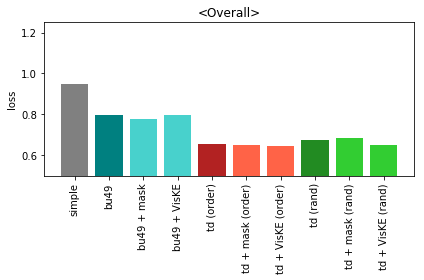

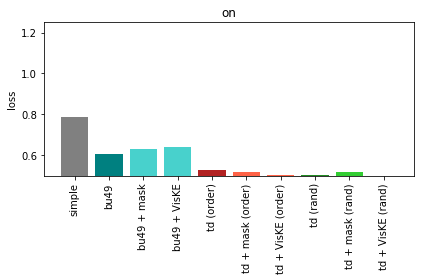

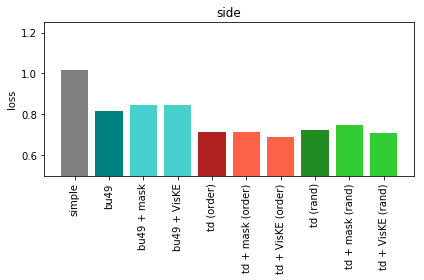

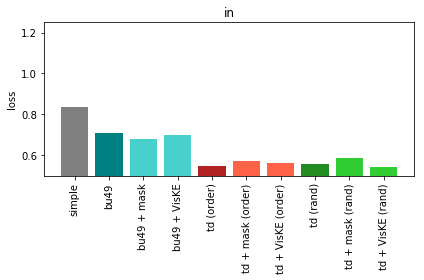

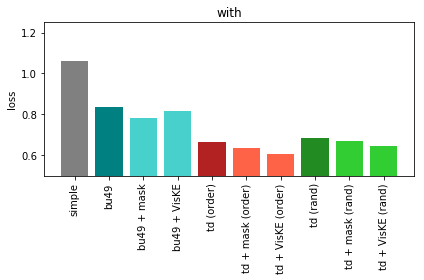

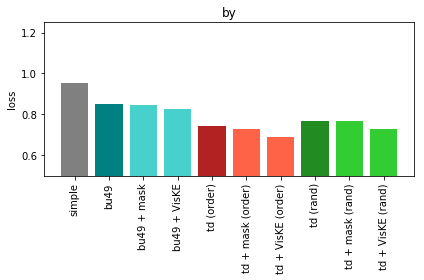

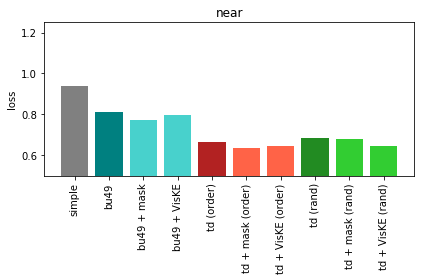

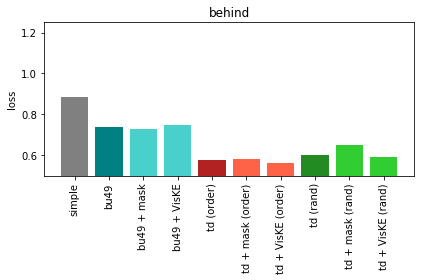

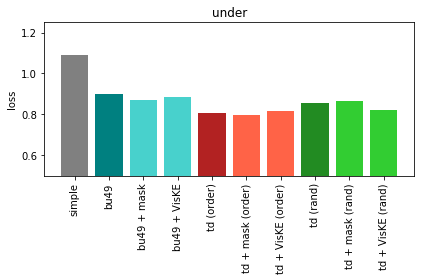

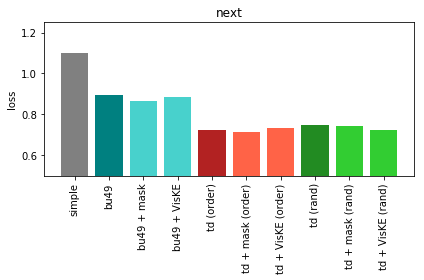

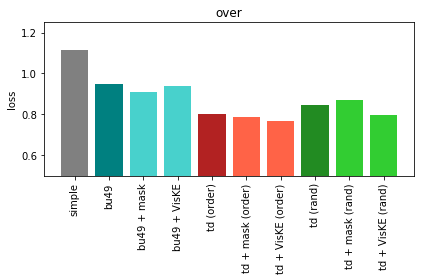

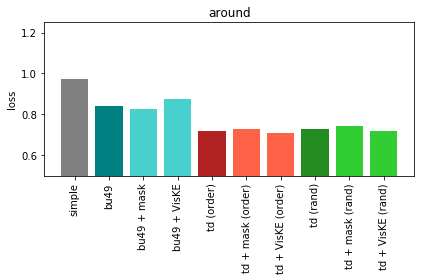

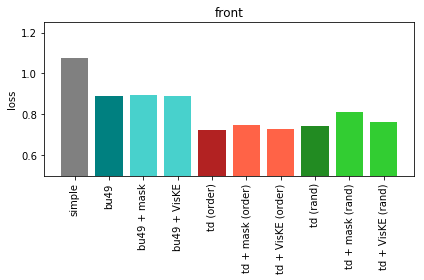

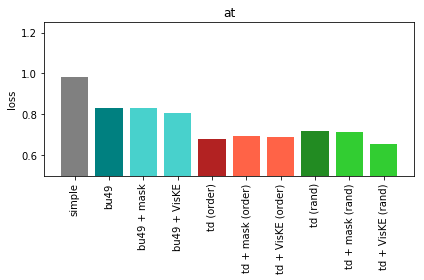

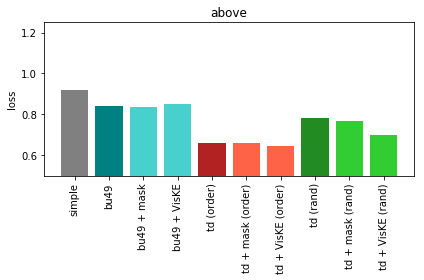

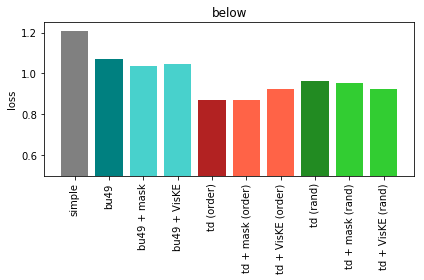

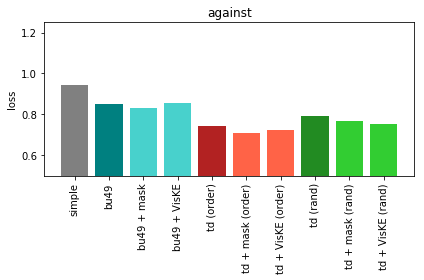

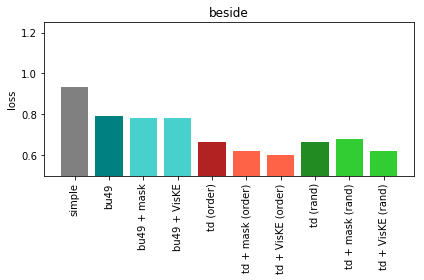

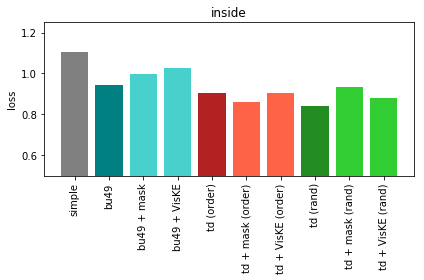

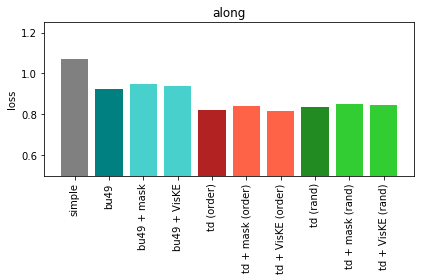

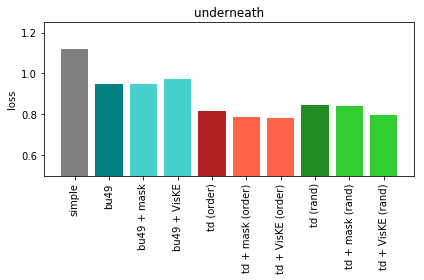

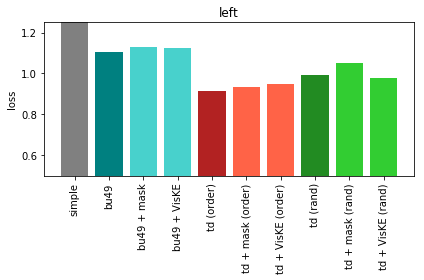

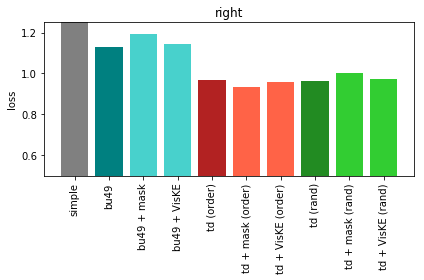

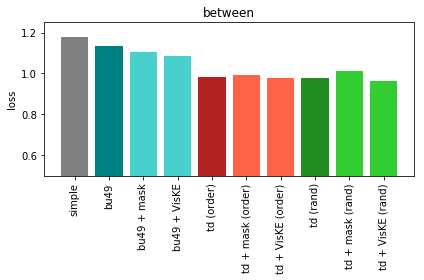

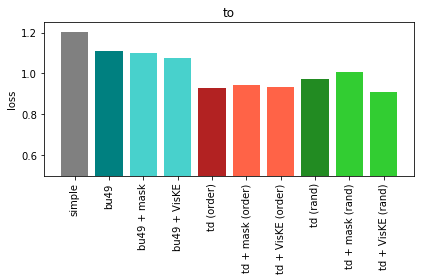

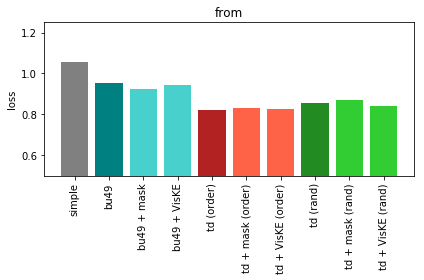

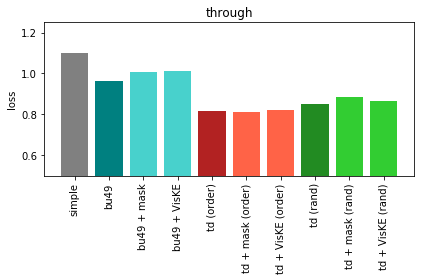

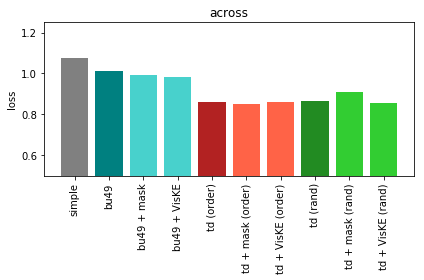

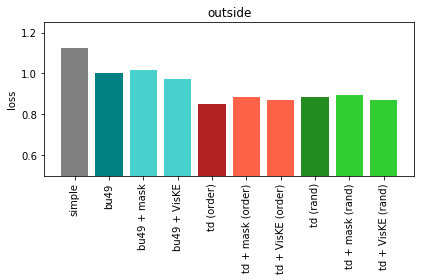

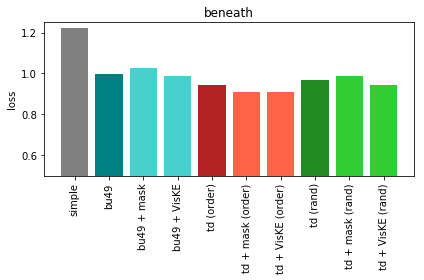

In [8]:
plot_model_ablation(results)

## Attention probes

### Plot average-normal attentions for word sequences

In [24]:
def plot_normal_attention_per_sequence(save_dir = None):
    # separately plot these sets of side by side charts:
    mode2plotorders = {
        'order': {
            # (mode, feed order): 0:left-plot. 1:right-plot
            ('implicit', (0,1)):  0, 
            ('bbox',     (0,1)):  1,
        },
        'random': {
            ('implicit-r', (0,1)): 0,
            ('bbox-r',     (0,1)): 1,
        }
    }
    
    for plt_subject, mode2plotorder in mode2plotorders.items():
        for rel, atts in att_results.items():

            fig, axs = plt.subplots(1, 2, sharex='col', sharey='row', gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
            fig.set_figheight(2)
            fig.set_figwidth(7)

            plt.suptitle(r'Normalized-Avg $\alpha_{{{0}}}$'.format(rel if rel is not None else ''), y=1.01)
            for i, mode in enumerate(atts):
                for so in atts[mode]:
                    if (mode,so) not in mode2plotorder:
                        continue

                    # which plot?
                    ax = axs[mode2plotorder[(mode,so)]]

                    # what is the title?
                    if mode2plotorder[(mode,so)] == 0:
                        ax.set_title('No $sp$')
                    if mode2plotorder[(mode,so)] == 1:
                        ax.set_title('VisKE')

                    # what are the values to be plotted?
                    norms, alpha, sents = atts[mode][so]

                    # normalisation of alpha
                    a = norms * alpha
                    a = a / np.expand_dims(a.sum(-1), -1)

                    # averaged over samples dimension
                    a = a.mean(0)

                    # mask 
                    sents_mask = np.expand_dims(np.array(sents != 0, dtype=np.float), 2)
                    sents_mask = sents_mask.max(0)
                    a = a * sents_mask
                    lim_seq = (a != 0).sum(0)[0]

                    # plots here. (does it have geometric spatial features?)
                    if a.shape[-1] == 4:
                        line_v2 = ax.bar(range(lim_seq), np.sum(a[:lim_seq, :4], -1), label='$v_2$', color='slateblue')
                        line_v1 = ax.bar(range(lim_seq), np.sum(a[:lim_seq, :3], -1), label='$v_1$', color='firebrick')
                        line_sp = ax.bar(range(lim_seq), np.sum(a[:lim_seq, :2], -1), label='sp', color='green')
                        line_lm = ax.bar(range(lim_seq), np.sum(a[:lim_seq, :1], -1), label='lm', color='gray')
                    else:
                        line_v2 = ax.bar(range(lim_seq), np.sum(a[:lim_seq, :3], -1), label='$v_2$', color='slateblue')
                        line_v1 = ax.bar(range(lim_seq), np.sum(a[:lim_seq, :2], -1), label='$v_1$', color='firebrick')
                        line_lm = ax.bar(range(lim_seq), np.sum(a[:lim_seq, :1], -1), label='lm', color='gray')

                    # ticks and labels
                    ax.set_xticks(range(lim_seq))
                    ax.set_yticks([0.25, 0.5, 0.75])



            # Put a legend below current axis
            fig.legend(
                handles=(line_v1, line_v2, line_sp, line_lm),
                labels=('$target$', '$landmark$', 'spatial', 'language'),
                loc='lower center',
                bbox_to_anchor=(0.46, -0.01),
                fancybox=True,
                shadow=True,
                ncol=4,
            )
            plt.tight_layout()
            plt.subplots_adjust(bottom=0.3)

            # save to file?
            if save_dir is not None:
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                    
                plt.savefig(save_dir+'/{1}_{0}.pdf'.format(rel if rel is not None else 'all', plt_subject), bbox_inches = "tight")
                
            plt.show()

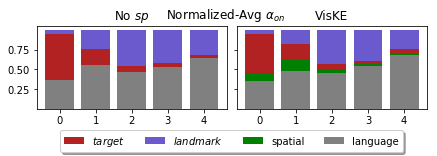

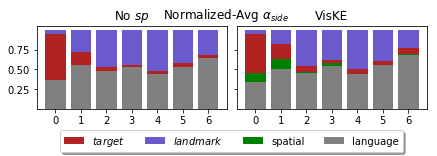

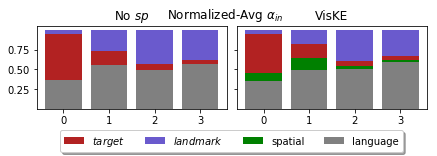

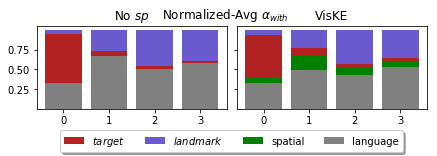

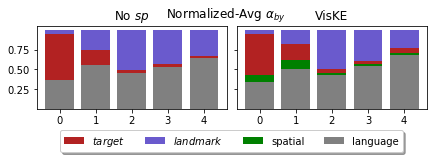

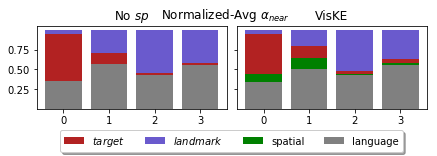

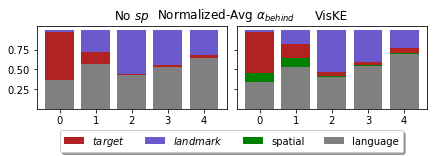

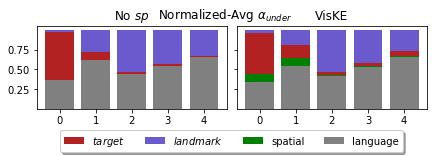

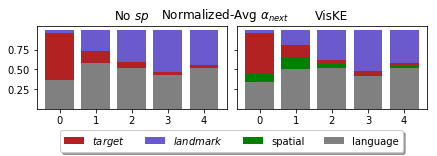

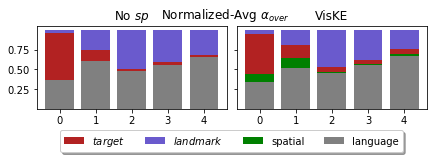

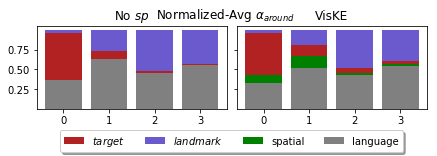

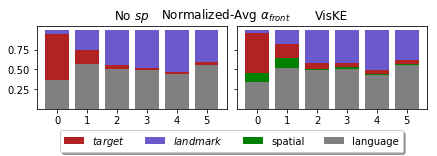

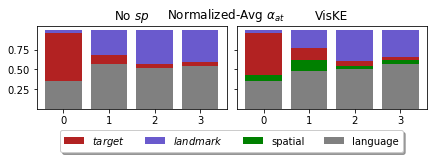

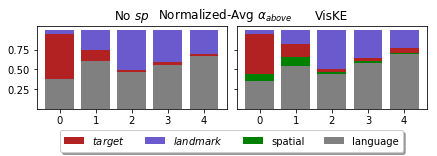

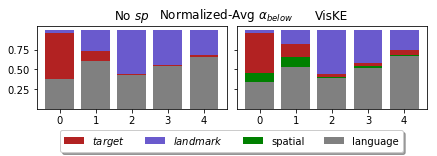

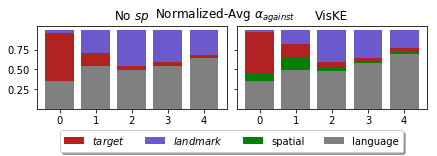

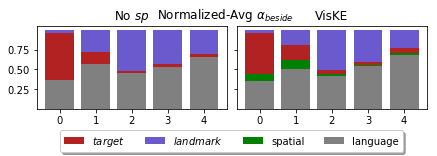

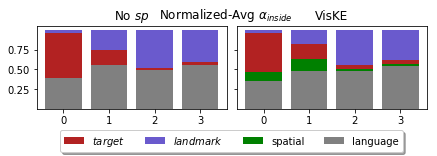

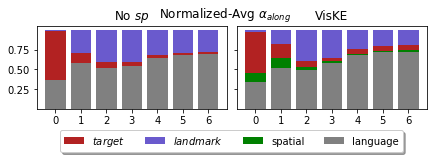

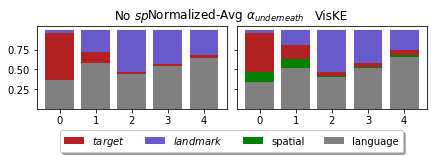

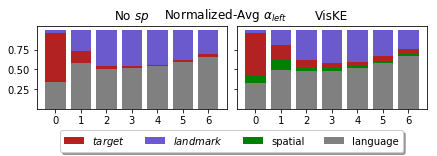

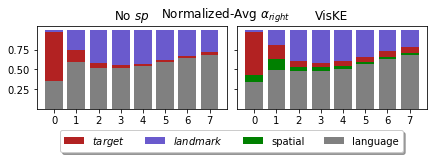

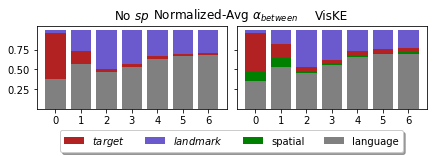

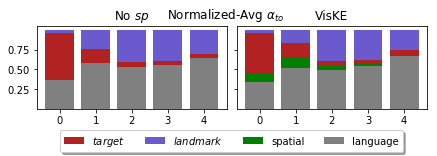

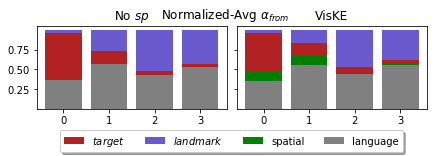

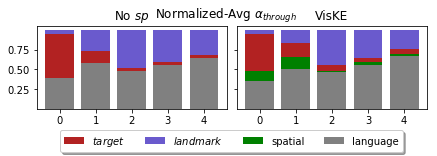

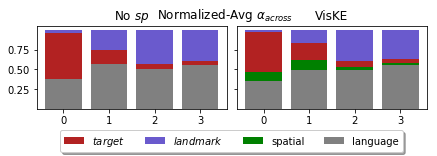

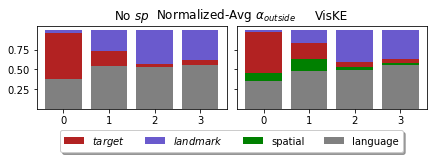

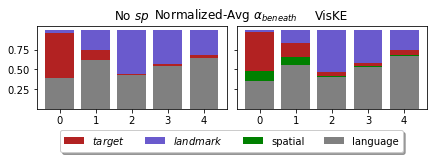

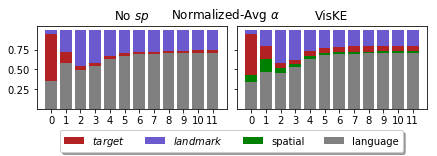

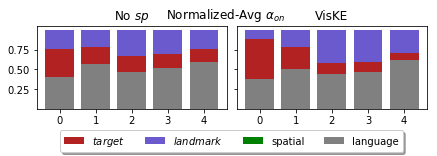

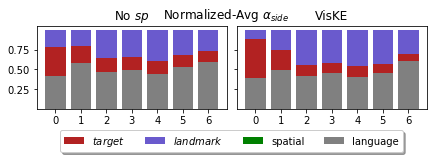

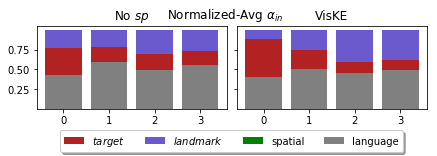

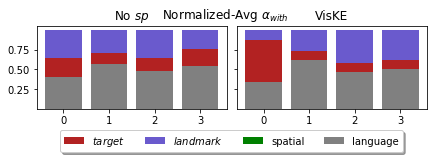

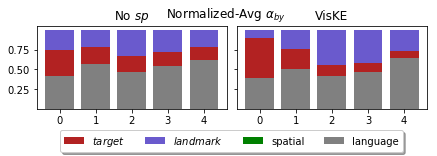

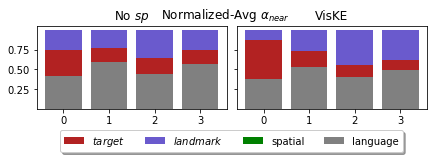

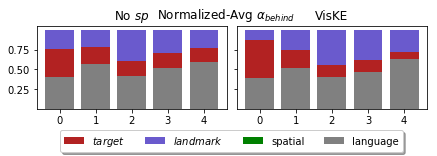

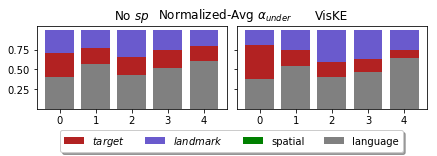

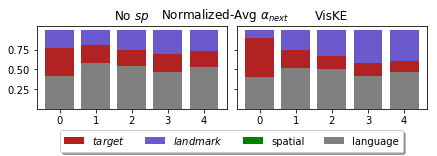

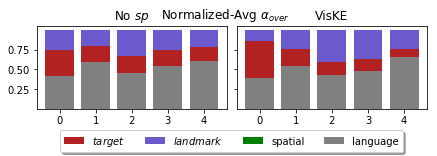

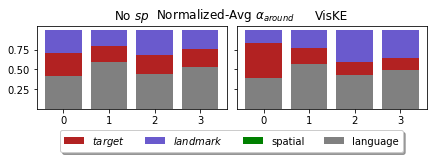

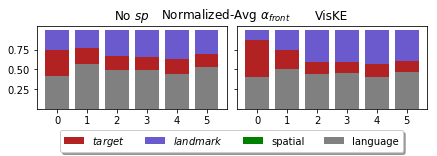

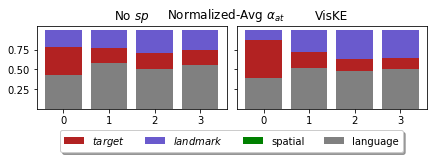

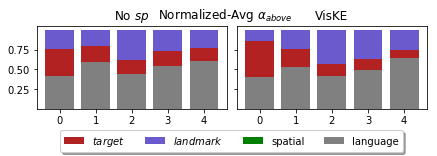

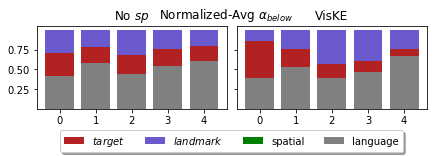

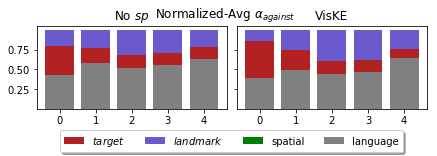

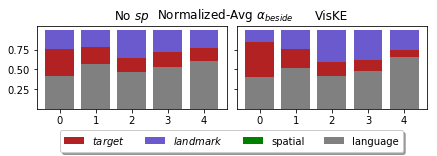

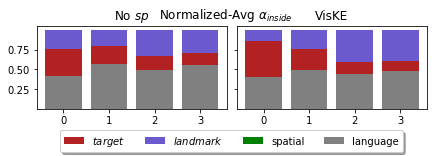

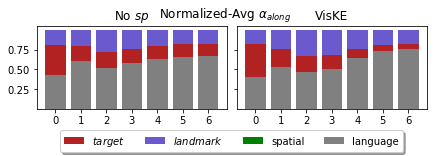

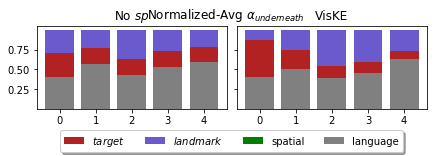

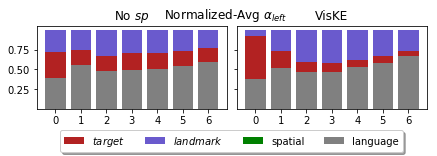

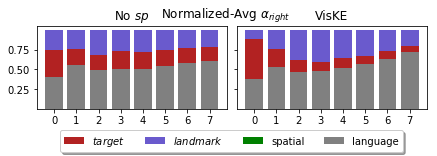

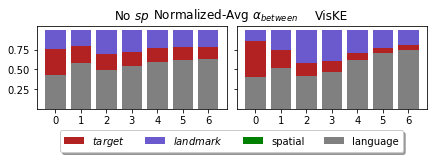

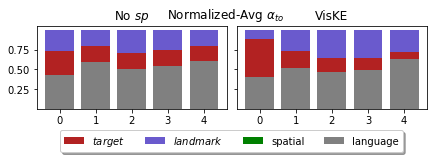

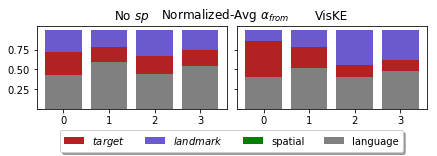

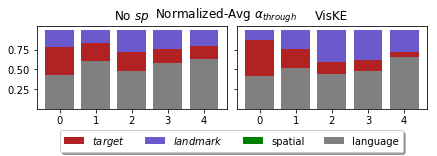

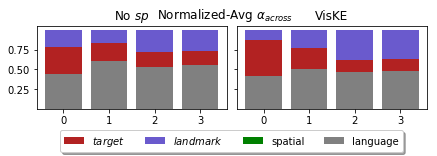

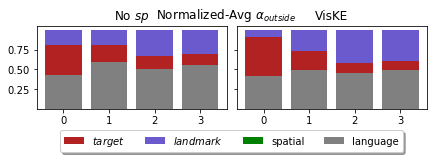

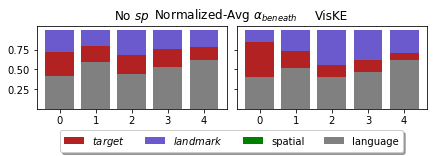

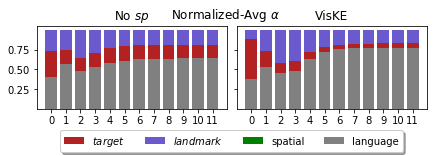

In [25]:
plot_normal_attention_per_sequence()

### Plot images with attentions

In [26]:
def bbox2patch(bbox, c, linestyle='-'):
    x, y, w, h = bbox
    #w0 = images[img_id]['width']
    #h0 = images[img_id]['height']
    return patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=c, facecolor='none', fill=False, alpha=0.5, linestyle=linestyle)


In [40]:
def plot_images_with_attentions(examples_path = None):
    # for each attention results (based samples in each bucket of relation)
    for rel in att_results:
        if rel is None:
            continue

        # find the image, and the bounding boxes associated with each sample
        for i, (img_id, (trg,_,bbox1), rel, (lnd,_,bbox2)) in enumerate(buckets[rel]):

            # the keyword of the relations 
            _rel = composit2simple[rel]

            # three different ways
            norm1, alpha1 = att_results[_rel]['bbox'][(0,1)][0][i], att_results[_rel]['bbox'][(0,1)][1][i]
            norm2, alpha2 = att_results[_rel]['bbox-r'][(0,1)][0][i], att_results[_rel]['bbox-r'][(0,1)][1][i]
            norm3, alpha3 = att_results[_rel]['implicit-r'][(0,1)][0][i], att_results[_rel]['implicit-r'][(0,1)][1][i]

            # figuer out the path
            filename = images[img_id]['path'].format(vg_dir)
            # normalisation!
            a1 = norm1 * alpha1
            a1 = a1 / np.expand_dims(a1.sum(-1), -1)

            a2 = norm2 * alpha2
            a2 = a2 / np.expand_dims(a2.sum(-1), -1)

            a3 = norm3 * alpha3
            a3 = a3 / np.expand_dims(a3.sum(-1), -1)

            # attention on the image
            a = a1

            # read the image from file
            img = np.asarray(Image.open(filename))

            # make a copy for each bounding box
            A = img.copy()
            bbox1_content = A[bbox1[1]:bbox1[1]+bbox1[3], bbox1[0]:bbox1[0]+bbox1[2]]
            bbox2_content = A[bbox2[1]:bbox2[1]+bbox2[3], bbox2[0]:bbox2[0]+bbox2[2]]

            A1 = np.ones_like(A) * 255
            A1[bbox1[1]:bbox1[1]+bbox1[3], bbox1[0]:bbox1[0]+bbox1[2]] = bbox1_content

            A2 = np.ones_like(A) * 255
            A2[bbox1[1]:bbox1[1]+bbox1[3], bbox1[0]:bbox1[0]+bbox1[2]] = bbox1_content
            A2[bbox2[1]:bbox2[1]+bbox2[3], bbox2[0]:bbox2[0]+bbox2[2]] = bbox2_content

            A3 = np.ones_like(A) * 255
            A3[bbox2[1]:bbox2[1]+bbox2[3], bbox2[0]:bbox2[0]+bbox2[2]] = bbox2_content

            x_min = min(bbox1[0], bbox2[0])
            y_min = min(bbox1[1], bbox2[1])
            x_max = max(bbox1[0]+bbox1[2], bbox2[0]+bbox2[2])
            y_max = max(bbox1[1]+bbox1[3], bbox2[1]+bbox2[3])


            bbox0 = (
                x_min - int(0.02*x_max+1),
                y_min - int(0.02*x_max+1),
                x_max-x_min + 2*int(0.02*x_max+1),
                y_max-y_min + 2*int(0.02*x_max+1),
            )

            fig = plt.figure(figsize=(10,5))

            ax0 = plt.subplot(341)
            ax0.set_xticks([])
            ax0.set_yticks([])

            ax1 = plt.subplot(342)
            ax1.set_xticks([])
            ax1.set_yticks([])
            ax1.set_xlabel(trg)

            ax2 = plt.subplot(343)
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.set_xlabel(rel)

            ax3 = plt.subplot(344)
            ax3.set_xticks([])
            ax3.set_yticks([])
            ax3.set_xlabel(lnd)

            ax0.imshow(A, alpha=1, interpolation = 'bicubic')


            rect1 = bbox2patch(bbox1, 'red')
            rect2 = bbox2patch(bbox2, 'blue')
            a_lm = np.mean(a[:len(trg.split(' ')), 0], 0)
            a_trg = np.mean(a[:len(trg.split(' ')), 2], 0)
            a_lnd = np.mean(a[:len(trg.split(' ')), 3], 0)
            ax1.imshow(A1, alpha=a_trg, interpolation = 'bicubic')
            ax1.imshow(A3, alpha=a_lnd, interpolation = 'bicubic')
            ax1.imshow(A, alpha=0.05, interpolation = 'bicubic')
            if a_trg > a_lnd and a_trg > a_lm:
                ax1.add_patch(rect1)
                ax1.text(bbox1[0], bbox1[1], r'$\hat{\alpha}=$'+'{0:0.2f}'.format(a_trg), color='white', bbox=dict(facecolor='red', alpha=0.4, linewidth=0))
            elif a_lnd > a_lm:
                ax1.add_patch(rect2)
                ax1.text(bbox2[0], bbox2[1], r'$\hat{\alpha}=$'+'{0:0.2f}'.format(a_lnd), color='white', bbox=dict(facecolor='blue', alpha=0.4, linewidth=0))


            rect1 = bbox2patch(bbox1, 'red')
            rect2 = bbox2patch(bbox2, 'blue')
            a_lm = np.mean(a[len(trg.split(' ')):len(trg.split(' '))+len(rel.split(' ')), 0], 0)
            a_trg = np.mean(a[len(trg.split(' ')):len(trg.split(' '))+len(rel.split(' ')), 2], 0)
            a_lnd = np.mean(a[len(trg.split(' ')):len(trg.split(' '))+len(rel.split(' ')), 3], 0)
            ax2.imshow(A1, alpha=a_trg, interpolation = 'bicubic')
            ax2.imshow(A3, alpha=a_lnd, interpolation = 'bicubic')
            ax2.imshow(A, alpha=0.05, interpolation = 'bicubic')
            if a_trg > a_lnd and a_trg > a_lm:
                ax2.add_patch(rect1)
                ax2.text(bbox1[0], bbox1[1], r'$\hat{\alpha}=$'+'{0:0.2f}'.format(a_trg), color='white', bbox=dict(facecolor='red', alpha=0.4, linewidth=0))
            elif a_lnd > a_lm:
                ax2.add_patch(rect2)
                ax2.text(bbox2[0], bbox2[1], r'$\hat{\alpha}=$'+'{0:0.2f}'.format(a_lnd), color='white', bbox=dict(facecolor='blue', alpha=0.4, linewidth=0))
            #ax2.text(bbox0[0]+0.5*bbox0[2], bbox0[1], 'Relation', color='white', bbox=dict(facecolor='black', alpha=0.4))

            rect1 = bbox2patch(bbox1, 'red')
            rect2 = bbox2patch(bbox2, 'blue')
            a_lm = np.mean(a[len(trg.split(' '))+len(rel.split(' ')):len(trg.split(' '))+len(rel.split(' '))+len(lnd.split(' ')), 0], 0)
            a_trg = np.mean(a[len(trg.split(' '))+len(rel.split(' ')):len(trg.split(' '))+len(rel.split(' '))+len(lnd.split(' ')), 2], 0)
            a_lnd = np.mean(a[len(trg.split(' '))+len(rel.split(' ')):len(trg.split(' '))+len(rel.split(' '))+len(lnd.split(' ')), 3], 0)
            ax3.imshow(A1, alpha=a_trg, interpolation = 'bicubic')
            ax3.imshow(A3, alpha=a_lnd, interpolation = 'bicubic')
            ax3.imshow(A, alpha=0.05, interpolation = 'bicubic')
            if a_trg > a_lnd and a_trg > a_lm:
                ax3.add_patch(rect1)
                ax3.text(bbox1[0], bbox1[1], r'$\hat{\alpha}=$'+'{0:0.2f}'.format(a_trg), color='white', bbox=dict(facecolor='red', alpha=0.4, linewidth=0))
            else:
                ax3.add_patch(rect2)
                ax3.text(bbox2[0], bbox2[1], r'$\hat{\alpha}=$'+'{0:0.2f}'.format(a_lnd), color='white', bbox=dict(facecolor='blue', alpha=0.4, linewidth=0))

            # attention plot 
            lim_seq = len(trg.split(' '))+len(rel.split(' '))+len(lnd.split(' '))
            sent = trg.split(' ')+rel.split(' ')+lnd.split(' ')

            ax = plt.subplot(513)
            line_v2 = ax.bar(range(lim_seq), np.sum(a1[:lim_seq, :4], -1), label='$v_2$', color='slateblue')
            line_v1 = ax.bar(range(lim_seq), np.sum(a1[:lim_seq, :3], -1), label='$v_1$', color='firebrick')
            line_sp = ax.bar(range(lim_seq), np.sum(a1[:lim_seq, :2], -1), label='sp', color='green')
            line_lm = ax.bar(range(lim_seq), np.sum(a1[:lim_seq, :1], -1), label='lm', color='gray')
            ax.set_xticks(range(lim_seq))
            ax.set_xticklabels(sent)
            ax.set_ylabel('(c)')

            fig.legend(
                handles=(line_v1, line_v2, line_sp, line_lm),
                labels=('$target$', '$landmark$', 'spatial', 'language'),
                loc='lower center',
                bbox_to_anchor=(0.435, -0.0),
                fancybox=True,
                shadow=True,
                ncol=4,
            )

            ax = plt.subplot(514)
            line_v2 = ax.bar(range(lim_seq), np.sum(a2[:lim_seq, :4], -1), label='$v_2$', color='slateblue')
            line_v1 = ax.bar(range(lim_seq), np.sum(a2[:lim_seq, :3], -1), label='$v_1$', color='firebrick')
            line_sp = ax.bar(range(lim_seq), np.sum(a2[:lim_seq, :2], -1), label='sp', color='green')
            line_lm = ax.bar(range(lim_seq), np.sum(a2[:lim_seq, :1], -1), label='lm', color='gray')
            ax.set_xticks(range(lim_seq))
            ax.set_xticklabels(sent)
            ax.set_ylabel('(b)')

            ax = plt.subplot(515)
            line_v2 = ax.bar(range(lim_seq), np.sum(a3[:lim_seq, :3], -1), label='$v_2$', color='slateblue')
            line_v1 = ax.bar(range(lim_seq), np.sum(a3[:lim_seq, :2], -1), label='$v_1$', color='firebrick')
            #line_sp = ax.bar(range(lim_seq), np.sum(a3[:lim_seq, :2], -1), label='sp', color='green')
            line_lm = ax.bar(range(lim_seq), np.sum(a3[:lim_seq, :1], -1), label='lm', color='gray')
            ax.set_xticks(range(lim_seq))
            ax.set_xticklabels(sent)
            ax.set_ylabel('(a)')


            plt.tight_layout()
            plt.subplots_adjust(bottom=0.15)

            # where do we save the plot?
            if examples_path is not None:
                if not os.path.exists(examples_path):
                    os.makedirs(examples_path)

                if not os.path.exists(examples_path + '/{0}.pdf'.format('_'.join(sent).replace('/','_'))):
                    plt.savefig(examples_path + '/{0}.pdf'.format('_'.join(sent).replace('/','_')), bbox_inches = "tight", dpi=300)
            plt.show()


/nix/store/6z0karx7hmqlbzpbyw9mixig6wn0klcz-python3-3.7.3-env/lib/python3.7/site-packages/matplotlib/tight_layout.py:340: UserWarning: tight_layout not applied: number of rows in subplot specifications mustbe multiples of one another.
  warnings.warn('tight_layout not applied: '


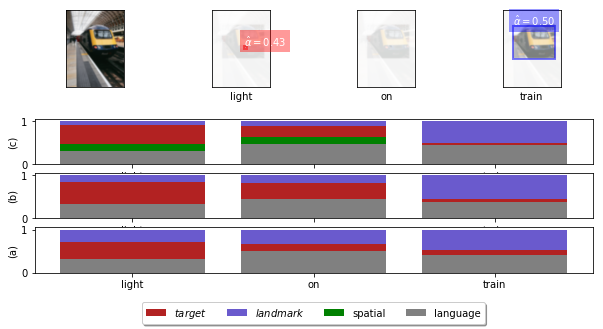

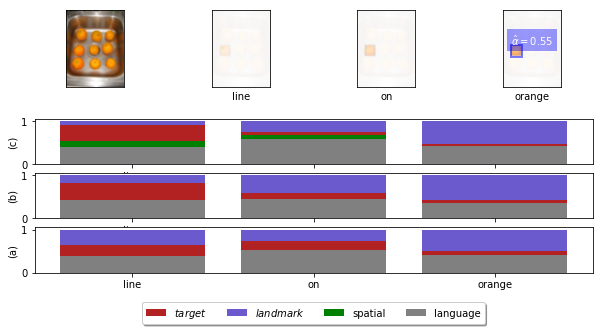

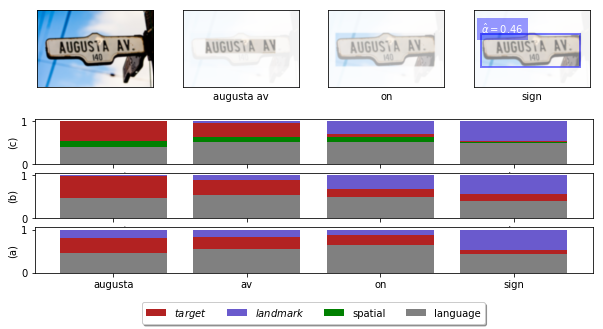

KeyboardInterrupt: 

In [41]:
plot_images_with_attentions()

### Plot triplets attention based on relaitons and models

In [100]:
def plot_attention_on_relations(target_relations):
    spatial_orders = [(0,1)]

    triplet_att_results_rearranged = dict()

    for i, rels in enumerate(target_relations):
        for j, rel in enumerate(rels):
            if rel not in triplet_att_results:
                continue
            for mode in triplet_att_results[rel]:
                for so in triplet_att_results[rel][mode]:
                    if so not in spatial_orders:
                        continue

                    if mode not in triplet_att_results_rearranged:
                        triplet_att_results_rearranged[mode] = dict()

                    triplet_att_results_rearranged[mode][rel] = np.array(triplet_att_results[rel][mode][so])
    

    for mode in triplet_att_results_rearranged:
        fig, axs = plt.subplots(*target_relations.shape)
        fig.suptitle(mode2title[mode])
        for i, rels in enumerate(target_relations):
            for j, rel in enumerate(rels):
                if rel not in triplet_att_results:
                    continue

                if target_relations.shape[0] > 1 and target_relations.shape[1] > 1:
                    ax = axs[i, j]
                elif target_relations.shape[0] > 1 and target_relations.shape[1] == 1:
                    ax = axs[i]
                elif target_relations.shape[0] == 1 and target_relations.shape[1] > 1:
                    ax = axs[j]
                elif target_relations.shape[0] == 1 and target_relations.shape[1] == 1:
                    ax = axs

                a = triplet_att_results_rearranged[mode][rel]
                a = a.mean(0)

                if a.shape[-1] == 4:
                    line_v2 = ax.bar(range(3), np.sum(a[:, :4], -1), label='$v_2$', color='slateblue')
                    line_v1 = ax.bar(range(3), np.sum(a[:, :3], -1), label='$v_1$', color='firebrick')
                    line_sp = ax.bar(range(3), np.sum(a[:, :2], -1), label='sp', color='green')
                    line_lm = ax.bar(range(3), np.sum(a[:, :1], -1), label='lm', color='gray')
                else:
                    line_v2 = ax.bar(range(3), np.sum(a[:, :3], -1), label='$v_2$', color='slateblue')
                    line_v1 = ax.bar(range(3), np.sum(a[:, :2], -1), label='$v_1$', color='firebrick')
                    line_lm = ax.bar(range(3), np.sum(a[:, :1], -1), label='lm', color='gray')

                # ticks and labels
                ax.set_xticks(range(3))

                if i == target_relations.shape[0]-1:
                    ax.set_xticklabels(['target', 'relation', 'landmark'], rotation=90)
                else: 
                    ax.set_xticklabels([])

                #ax.set_title(rel, )
                ax.text(x=-.35, y=0.15, s=rel, bbox=dict(facecolor='white', alpha=0.25))
                ax.set_yticks([0.25, 0.5, 0.75])

        plt.show()



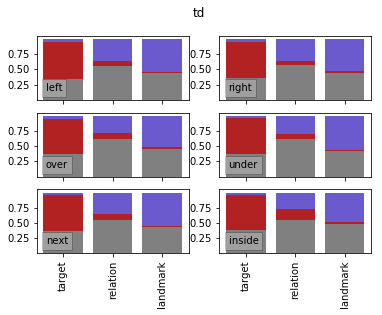

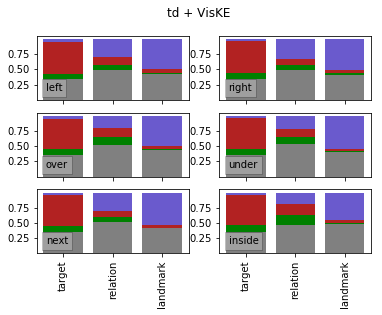

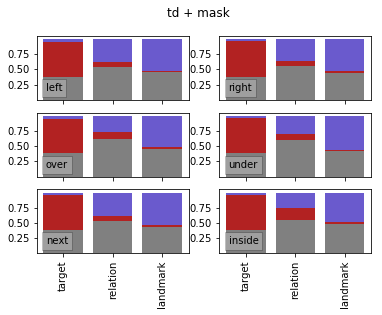

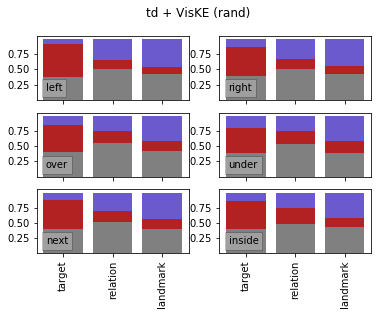

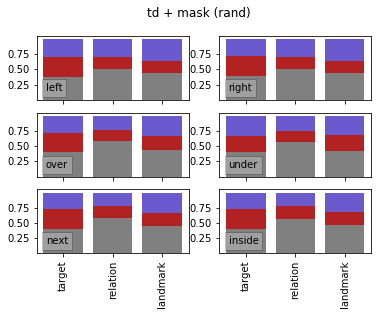

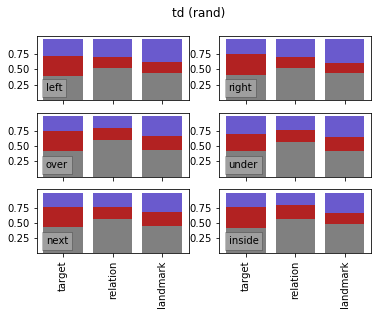

In [101]:
target_relations = np.array([
    ['left', 'right'],
    ['over', 'under'], 
    ['next', 'inside']
])

plot_attention_on_relations(target_relations)

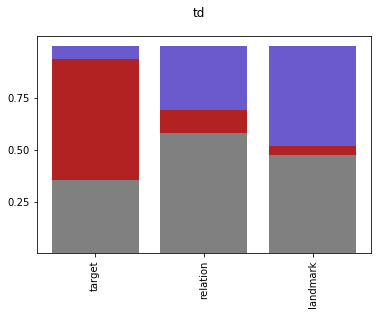

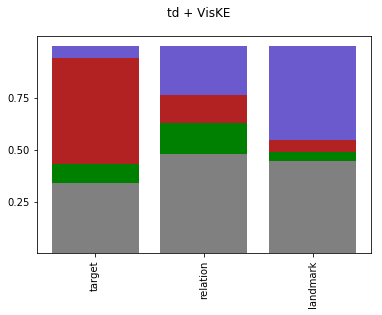

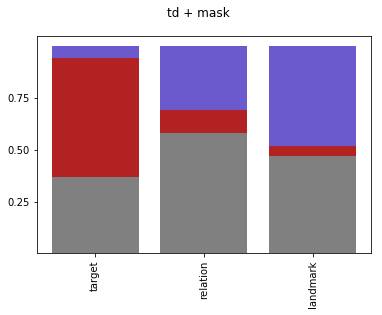

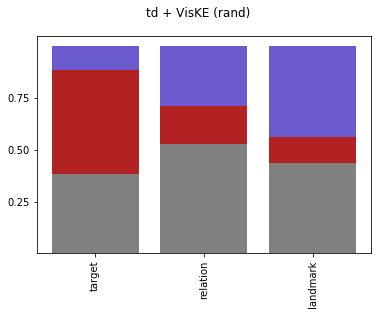

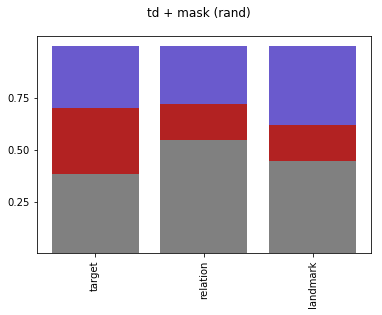

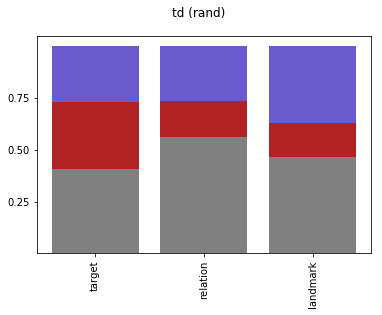

In [102]:
target_relations = np.array([
    [None,],
])

plot_attention_on_relations(target_relations)